In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pymongo import MongoClient
import copy
import math
from enum import Enum
import requests
import json
import pprint
from os import listdir
import dill
dill.settings['recurse'] = True
from pathos.multiprocessing import ProcessingPool as Pool
import time
from pqdict import PQDict
from matplotlib import colors

userRatingPath = "./data/"

class CollectibleType(Enum):
  All = 1
  Hands = 2
  Feet = 3
  Left = 4
  Right = 5
  LeftHand = 6
  RightHand = 7
  LeftFoot = 8
  RightFoot = 9

gravity = 9.81

client = MongoClient('localhost', 27017)

db = client['beatfork']

# todo: dedupe objects
versions = db.versions.find()
def objectDedupe(version):
  lastObject = version['objects'][0]
  for i in range(1, len(version['objects'])):
    if (lastObject['type'] == version['objects'][i]['type'] and
        (lastObject['type'] == 'Obstacle' or lastObject['collectibleType'] == version['objects'][i]['collectibleType']) and
        lastObject['position']['x'] == version['objects'][i]['position']['x'] and
        lastObject['position']['y'] == version['objects'][i]['position']['y'] and
        lastObject['position']['z'] == version['objects'][i]['position']['z']):
       version['objects'][i] = None
    else:
        lastObject = version['objects'][i] 
  version['objects'] = list(filter(lambda o: o, version['objects']))
  return version
versions = list(map(objectDedupe, versions))

userRatings = {}
for fileName in listdir(userRatingPath):
  file = open(userRatingPath + fileName)
  userRating = json.load(file)
  id = userRating['_id']['levelId'] + '/' + userRating['_id']['versionId']
  if not id in userRatings:
    userRatings[id] = {
      'overallDifficulty': [],
      'chunkDifficulties': []
    }
  userRatings[id]['overallDifficulty'].append(userRating['overallDifficulty'])
  userRatings[id]['chunkDifficulties'].append(userRating['chunkDifficulties'])
for version in userRatings:
  userRatings[version]['overallDifficulty'] = pd.DataFrame(userRatings[version]['overallDifficulty'])
  userRatings[version]['chunkDifficulties'] = pd.DataFrame(userRatings[version]['chunkDifficulties'])

sns.set(rc={'figure.figsize': (10, 3)})

def calcDistanceXY(posA, posB):
  return ( (posA['x'] - posB['x']) ** 2 + (posA['y'] - posB['y']) ** 2 ) ** (1 / 2)

def calcDistanceZ(posA, posB):
  return abs(posA['z'] - posB['z'])

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


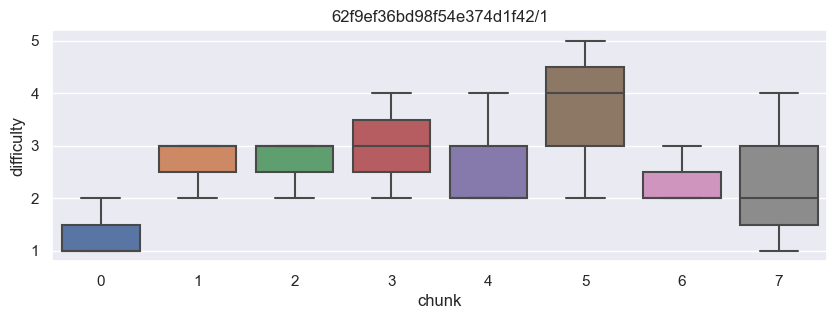

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


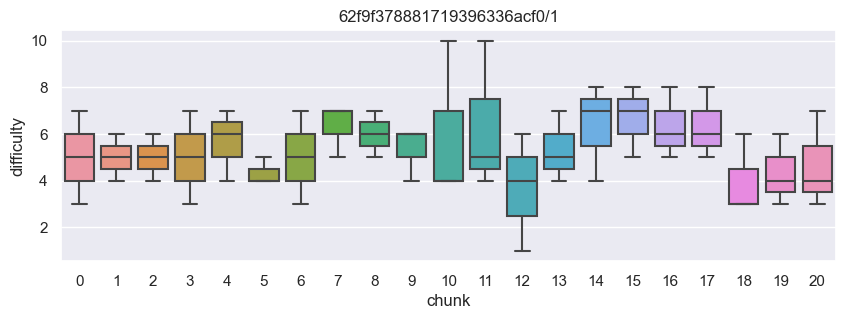

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


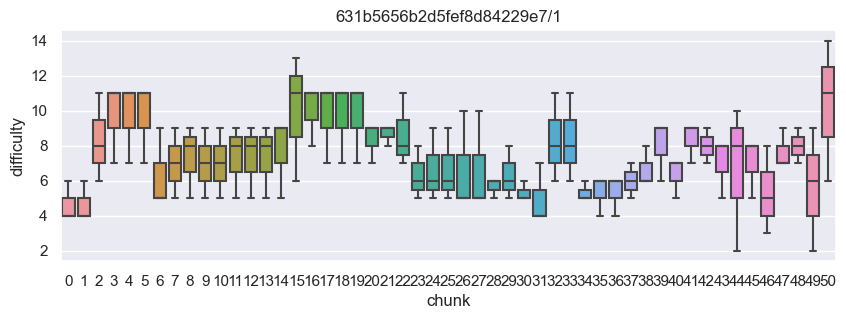

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


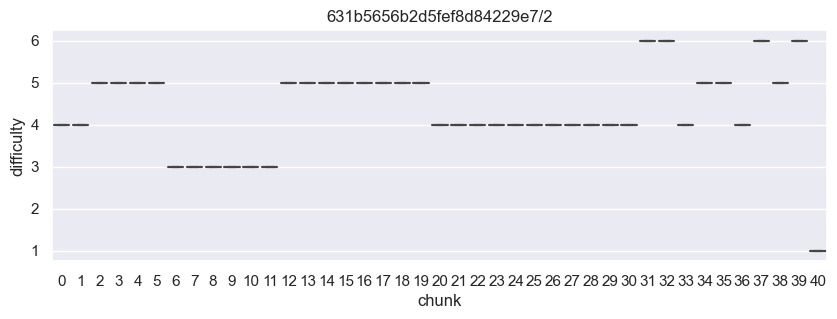

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


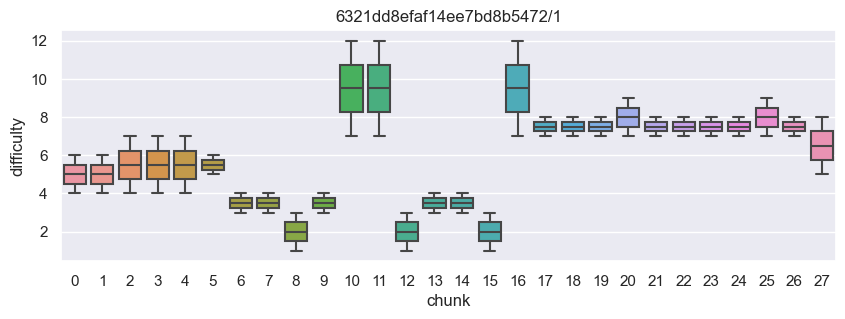

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


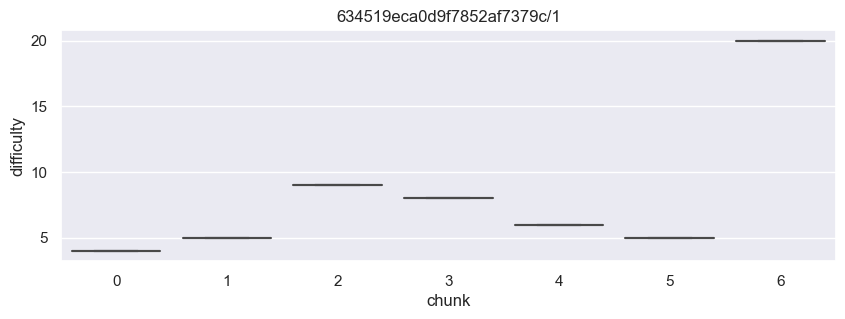

In [121]:
for version in userRatings:
  g = sns.boxplot(
    data=userRatings[version]['chunkDifficulties']
  )
  g.set_title(version)
  g.set_xlabel("chunk")
  g.set_ylabel("difficulty")
  plt.show()

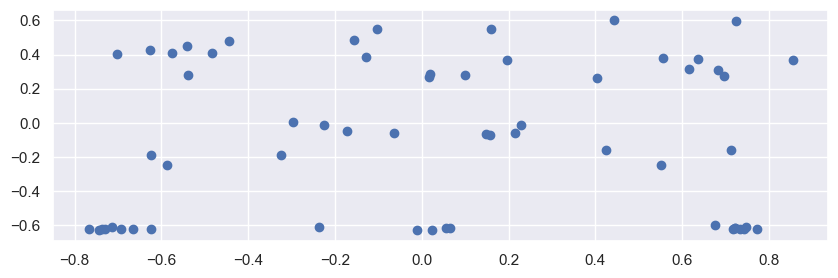

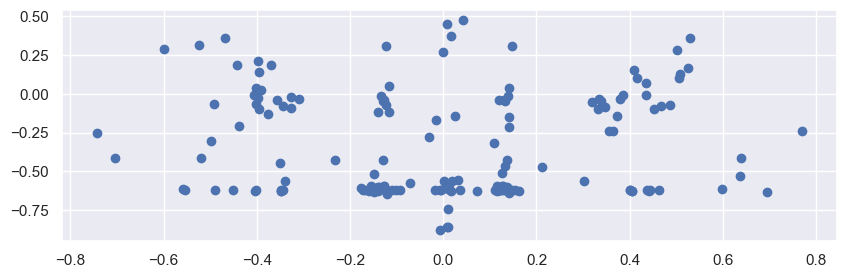

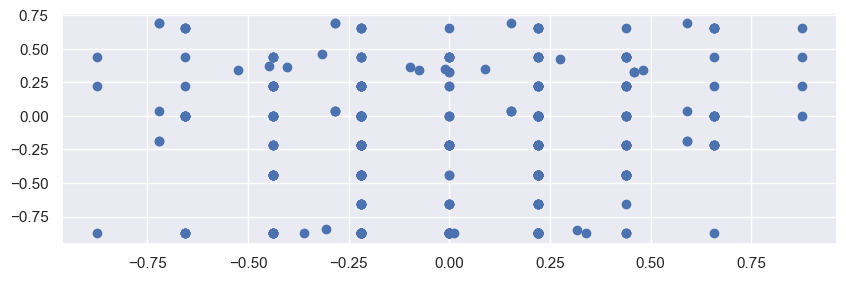

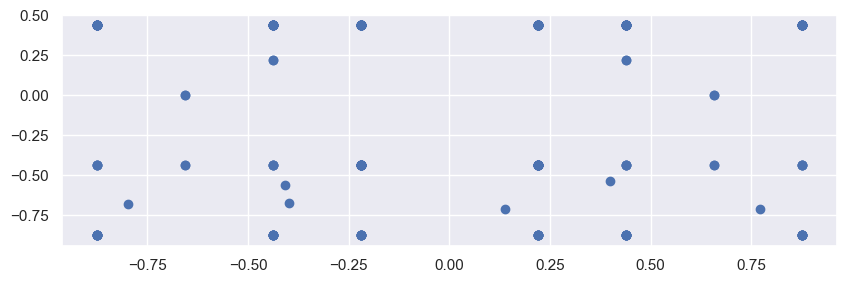

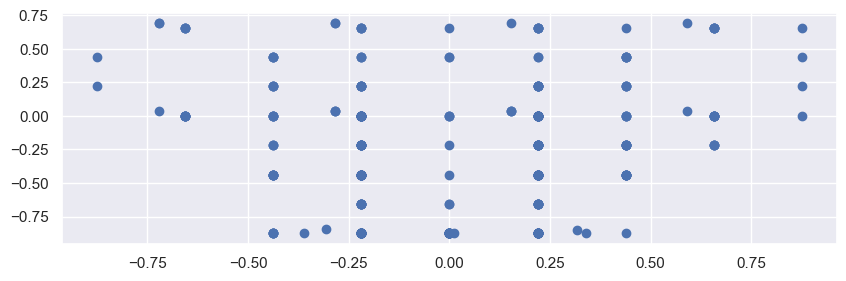

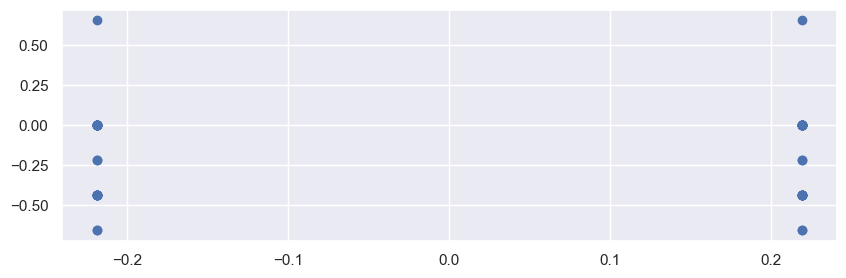

In [122]:
def plotXYOccurence(version):

  x = np.array(list(map(lambda obj:
    obj['position']['x']
  , version['objects'])))
  y = np.array(list(map(lambda obj:
    obj['position']['y']
  , version['objects'])))

  fig, ax = plt.subplots()

  ax.scatter(x, y, vmin=-1, vmax=1)

  plt.show()

for version in copy.deepcopy(versions):
  plotXYOccurence(version)

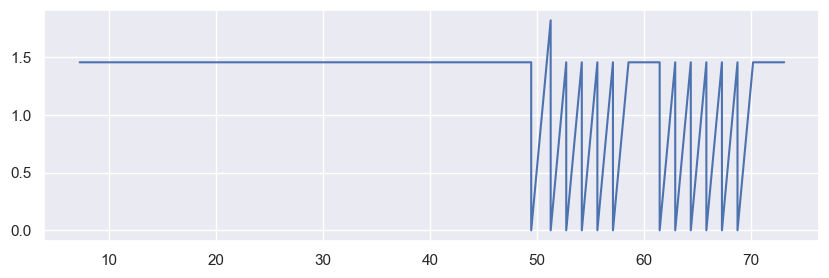

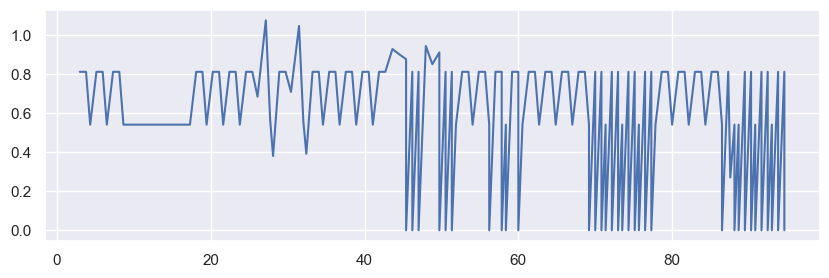

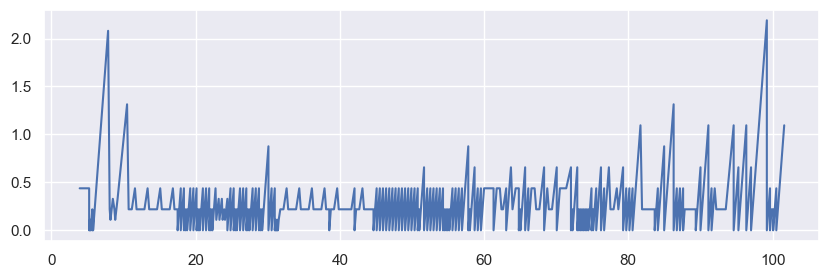

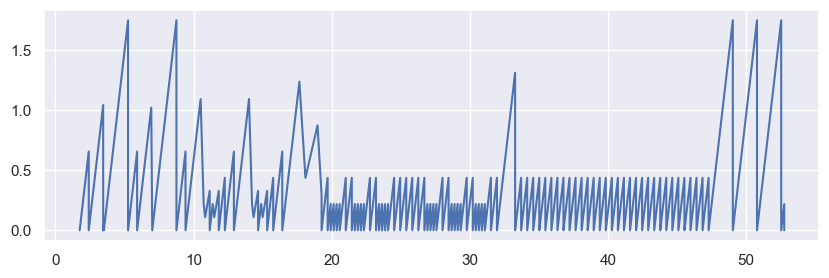

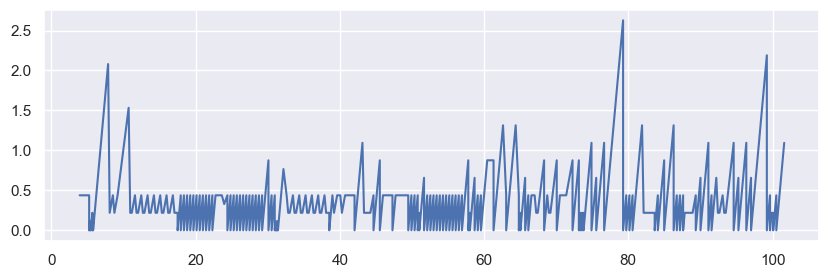

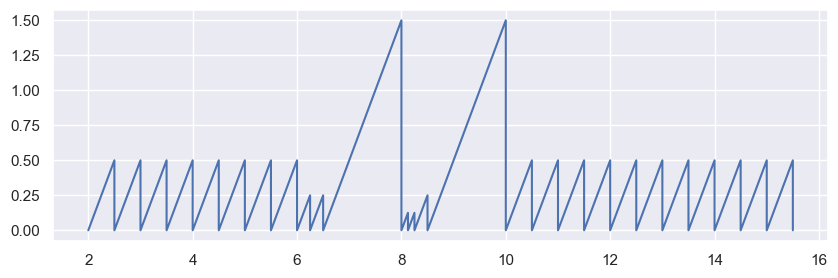

In [123]:
def plotZDistance(version):

  zDistanceBetweenBlocks = []
  lastZ = version['objects'].pop(0)['position']['z']
  for obj in version['objects']:
    zDistanceBetweenBlocks.append(obj['position']['z'] - lastZ)
    lastZ = obj['position']['z']

  x = np.array(list(map(lambda obj:
    obj['position']['z']
  , version['objects'])))
  y = np.array(zDistanceBetweenBlocks)

  fig, ax = plt.subplots()

  ax.plot(x, y)

  plt.show()

for version in copy.deepcopy(versions):
  plotZDistance(version)

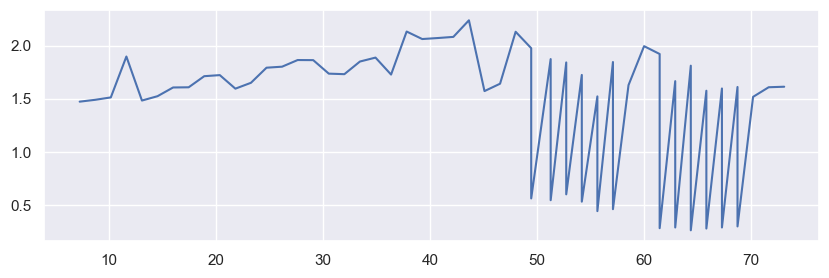

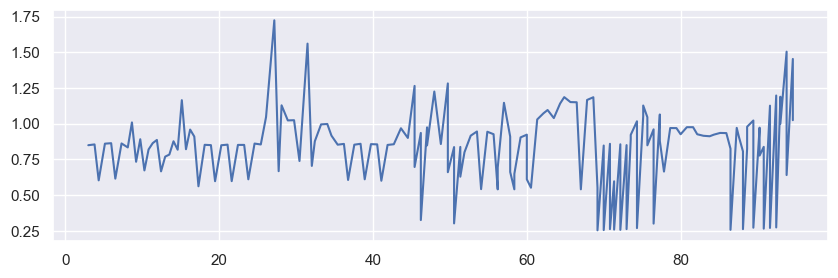

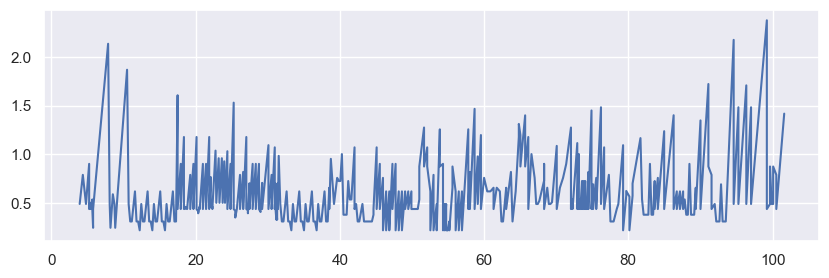

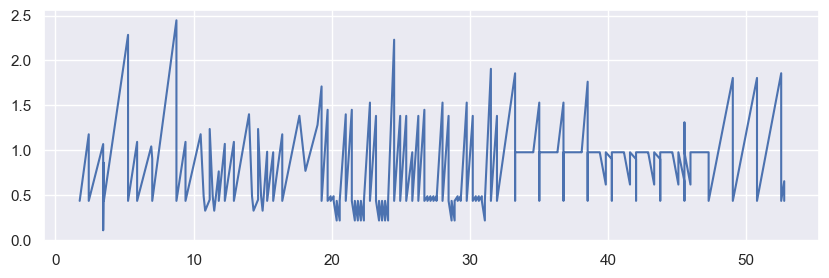

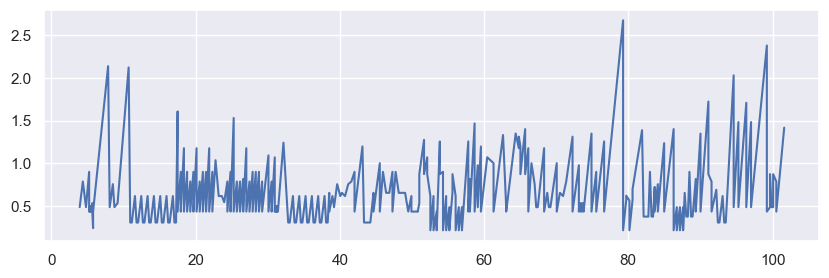

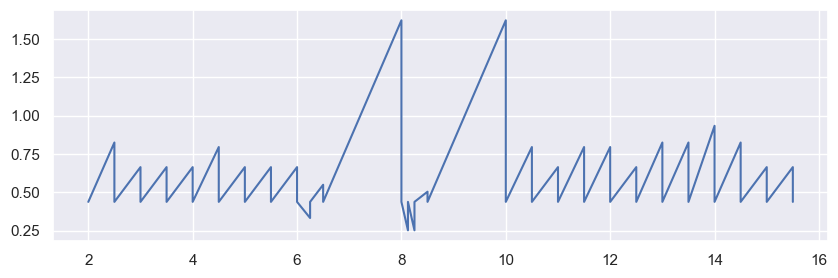

In [124]:
def plotDistance(version):

  distanceBetweenBlocks = []
  lastPosition = version['objects'].pop(0)['position']
  for obj in version['objects']:
    distanceBetweenBlocks.append((
      (obj['position']['x'] - lastPosition['x']) ** 2 +
      (obj['position']['y'] - lastPosition['y']) ** 2 +
      (obj['position']['z'] - lastPosition['z']) ** 2 ) ** 0.5)
    lastPosition = obj['position']

  x = np.array(list(map(lambda obj:
    obj['position']['z']
  , version['objects'])))
  y = np.array(distanceBetweenBlocks)

  fig, ax = plt.subplots()

  ax.plot(x, y)

  plt.show()

for version in copy.deepcopy(versions):
  plotDistance(version)

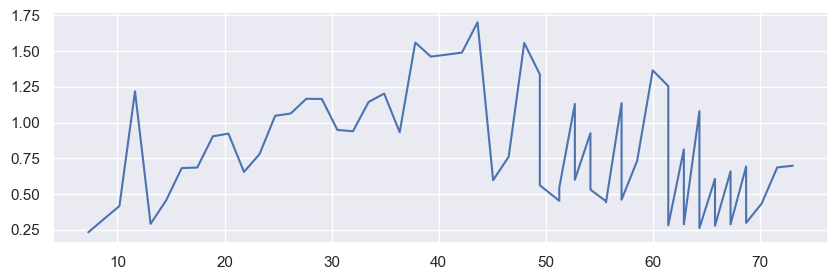

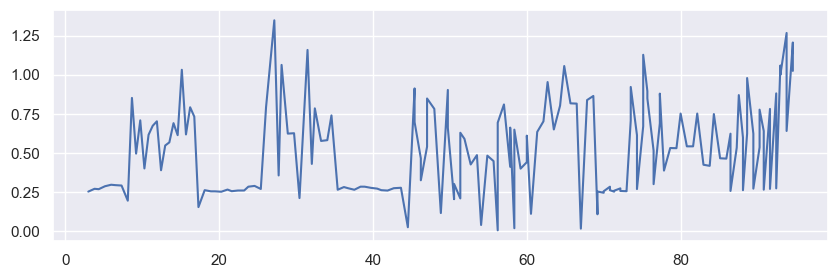

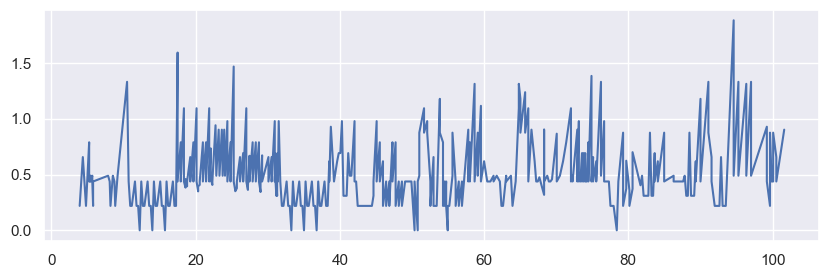

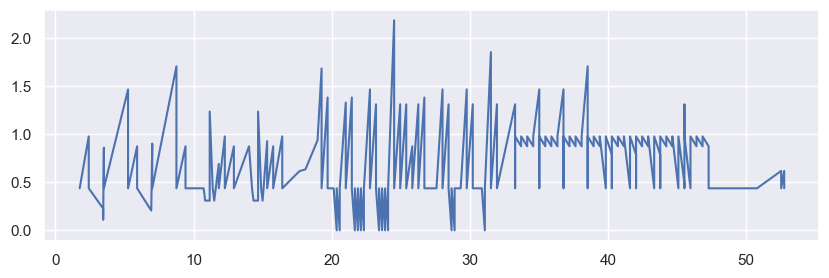

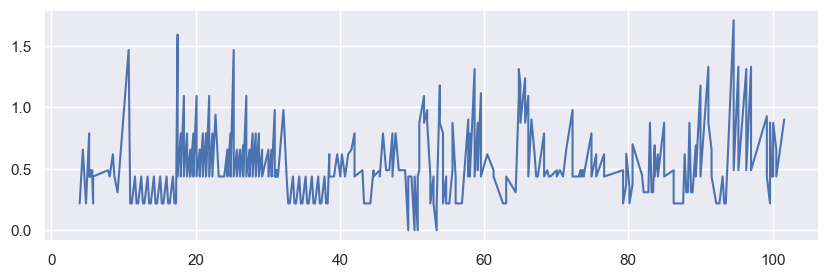

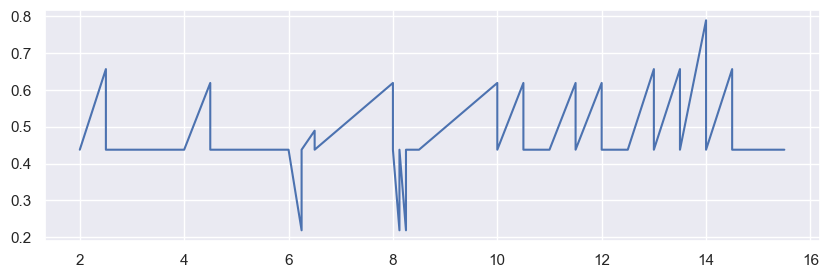

In [125]:
def plotXYDistance(version):

  distanceBetweenBlocks = []
  lastPosition = version['objects'].pop(0)['position']
  for obj in version['objects']:
    distanceBetweenBlocks.append((
      (obj['position']['x'] - lastPosition['x']) ** 2 +
      (obj['position']['y'] - lastPosition['y']) ** 2 ) ** 0.5)
    lastPosition = obj['position']

  x = np.array(list(map(lambda obj:
    obj['position']['z']
  , version['objects'])))
  y = np.array(distanceBetweenBlocks)

  fig, ax = plt.subplots()

  ax.plot(x, y)

  plt.show()

for version in copy.deepcopy(versions):
  plotXYDistance(version)

62f9ef36bd98f54e374d1f42/1


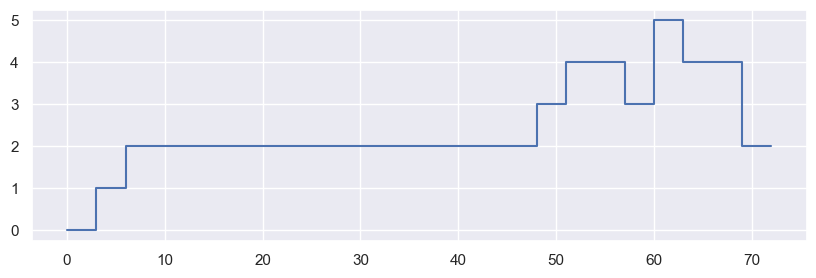

62f9f378881719396336acf0/1


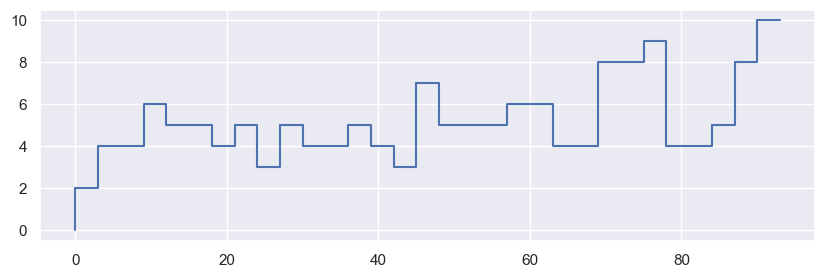

631b5656b2d5fef8d84229e7/1


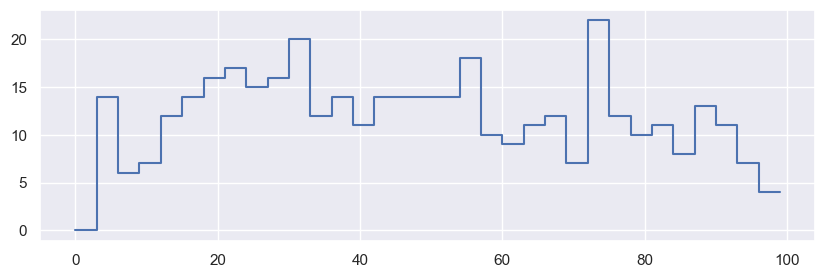

6321dd8efaf14ee7bd8b5472/1


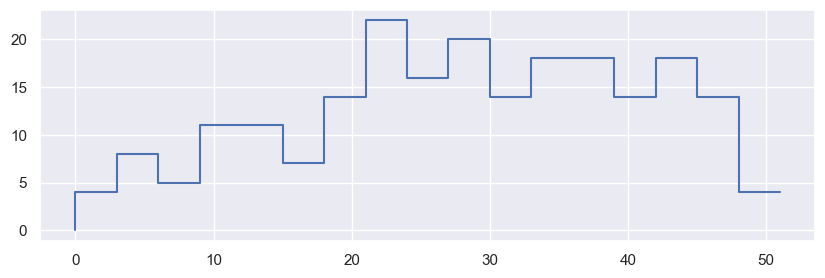

631b5656b2d5fef8d84229e7/2


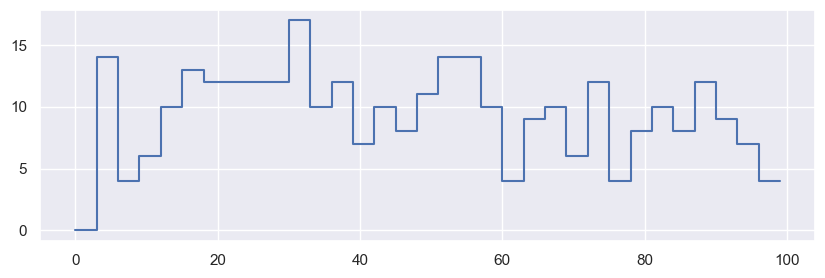

634519eca0d9f7852af7379c/1


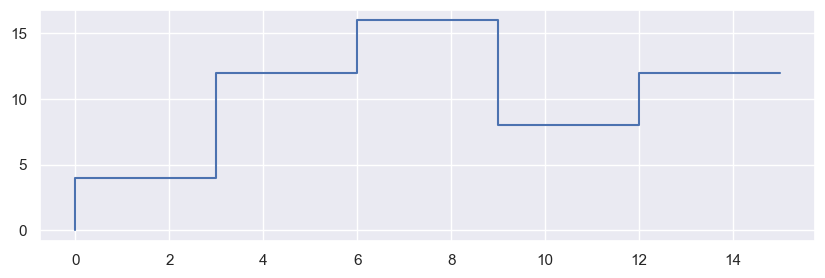

In [126]:
def plotDensity(version):
  secondsPerInterval = 3

  objects = version['objects']
  end = objects[-1]['position']['z']
  density = []
  for i in range(0, math.ceil(end / secondsPerInterval) * secondsPerInterval, secondsPerInterval):
    obstaclesInInterval = 0
    while len(objects) > 0 and objects[0]['position']['z'] < i:
      obstaclesInInterval += 1
      objects.pop(0)
    density.append(obstaclesInInterval)

  x = np.arange(0, math.ceil(end / secondsPerInterval) * secondsPerInterval, secondsPerInterval)
  y = np.array(density)

  fig, ax = plt.subplots()

  ax.step(x, y)

  plt.show()

for version in copy.deepcopy(versions):
  print(str(version['_id']['levelId']) + '/' + str(version['_id']['versionId']))
  plotDensity(version)

In [127]:
# Sampling (like in signal processing)
# 
# Sampled naive algorithm is still very slow even with low chunk sizes as 8 it takes about 10s to run per level version.
# Converting to JS failed, because JS cannot deal with soo many recursions without further steps.
# Maybe rewrite iteratively. Does that solve the problem though?
# Definitely need more performance for larger chunk sizes.

chunkSize = 8
overlap = 0

def split(myList, chunkSize, overlap):
  for i in range (0, len(myList), chunkSize):
    yield myList[i: i + chunkSize + overlap]

def plotBestOptions(options, chunkSize):

  def removeInf(option):
    for limb in option.values():
      if limb == math.inf:
        option = {
          6: 0,
          7: 0,
          8: 0,
          9: 0,
        }
        return option
    return option

  for version in options:
    fig, ax = plt.subplots()
    plt.ylim([0, 20]) # todo

    options[version] = list(map(removeInf, options[version]))

    chunkLabels = list(range(0, len(options[version])))
    leftHandIntensity = np.array(list(map(lambda option:
      option[CollectibleType.LeftHand.value]
      , options[version])))
    rightHandIntensity = np.array(list(map(lambda option:
      option[CollectibleType.RightHand.value]
      , options[version])))
    leftFootIntensity = np.array(list(map(lambda option:
      option[CollectibleType.LeftFoot.value]
      , options[version])))
    rightFootIntensity = np.array(list(map(lambda option:
      option[CollectibleType.RightFoot.value]
      , options[version])))
    ax.bar(chunkLabels, leftHandIntensity, label='Left Hand', bottom = np.add(leftFootIntensity, rightFootIntensity), zorder=1)
    ax.bar(chunkLabels, rightHandIntensity, label='Right Hand', bottom = np.add(np.add(leftFootIntensity, rightFootIntensity), leftHandIntensity), zorder=1)
    ax.bar(chunkLabels, leftFootIntensity, label='Left Foot', zorder=1)
    ax.bar(chunkLabels, rightFootIntensity, label='Right Foot', bottom=leftFootIntensity, zorder=1)
    ax.legend()

    ax.boxplot(userRatings[version]['chunkDifficulties'], positions=list(range(0, userRatings[version]['chunkDifficulties'].shape[1])), zorder=2)

    plt.title(version)
    plt.xlabel("chunk")
    plt.ylabel("difficulty")

    plt.show()

In [128]:
def rightLegAmputeeIntensity(obj, lastPositions):
  if (obj[3] == 9):
    return math.inf
  distance = ((lastPositions[obj[3]][0] - obj[0]) ** 2 + (lastPositions[obj[3]][1] - obj[1]) ** 2) ** 0.5
  time = abs(lastPositions[obj[3]][2] - obj[2])
  if (distance == 0):
    return 0
  if (time == 0):
    return math.inf
  return distance / time

# plotSampledGetMinIntensity(rightLegAmputeeIntensity)

In [129]:
def handsHeightDifficultyFactor(height):
  # return ((height - 0.1) ** 6 + 1)
  return (1.2 * height - 0.4) ** 4 - (0.2 * height) ** 6 + 0.2


def feetHeightDifficultyFactor(height):
  return ((height + 0.875) ** 2.8 + 1)

def intensity2(obj, lastPositions):
  distance = ((lastPositions[obj[3]][0] - obj[0]) ** 2 + (lastPositions[obj[3]][1] - obj[1]) ** 2) ** 0.5
  time = abs(lastPositions[obj[3]][2] - obj[2])

  # General edge cases
  if (distance == 0):
    return 0
  if (time == 0):
    return math.inf

  # Hands
  if (obj[3] == 6 or obj[3] == 7):
    return distance / time * handsHeightDifficultyFactor(obj[1])
  # Feet
  elif (obj[3] == 8 or obj[3] == 9):
    # todo: 0 distance cannot mean 0 effort, if in air or balancing on a single leg
    return distance / time * feetHeightDifficultyFactor(obj[1])
  return math.inf

In [130]:
# todo remove start
def default(obj):
    if type(obj).__module__ == np.__name__:
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj.item()
    raise TypeError('Unknown type:', type(obj))
# todo remove end

def getMinIntensityDijkstra(objects, cumulatedIntensity, state, lastPosition, calcIntensity, trace):
  # todo: Will terminate when first value is written to last column. Use different data structure for less memory allocation?
  # Alternatively, refactor recursion anchor?
  noVertices = 4 ** (len(objects) + 1) + 1
  distances = [math.inf] * noVertices
  distances[0] = 0
  v = PQDict(zip(range(0, noVertices), distances))
  cumulatedIntensities = [cumulatedIntensity] * noVertices
  lastPositions = [lastPosition] * noVertices
  states = [state] * noVertices
  lastNode = 0

  for currentNode, currentIntensity in v.popitems():
    k = math.floor(math.log(12 * currentNode + 4, 4) - 1)
    if k == len(objects):
      i = currentNode
      limbStrings = ['lh', 'rh', 'lf', 'rf']
      newTracePart = ''
      traceCumulatedIntensity = None
      while i > 0:
        # newTracePart = limbStrings[(i - 1) % 4] + ' ' + newTracePart
        newTracePart = limbStrings[(i - 1) % 4] + ' ' + json.dumps(states[i], default=default) + ' ' + newTracePart
        i = (i - 1) // 4
      return (
        cumulatedIntensities[currentNode],
        states[currentNode],
        lastPositions[currentNode],
        trace + '\n| ' + newTracePart
      )
    for i in range(1, 5):
      j = 4 * currentNode + i 
      objType = objects[k][3]
      if  (objType == 1 
           or (objType == 2 and (i == 1 or i == 2))
           or (objType == 3 and (i == 3 or i == 4))
           or (objType == 4 and (i == 1 or i == 3))
           or (objType == 5 and (i == 2 or i == 4))
           or objType == 5 + i):
        obj = copy.deepcopy(objects[k])
        obj[3] = 5 + i
        cumulatedIntensities[j] = copy.deepcopy(cumulatedIntensities[currentNode])
        intensity, s = calcIntensity(obj, lastPositions[currentNode], states[currentNode])
        cumulatedIntensities[j][5 + i] += intensity
        states[j] = s
        lastPositions[j] = copy.deepcopy(lastPositions[currentNode])
        lastPositions[j][5 + i] = [objects[k][0], objects[k][1], objects[k][2]]
        v[j] = (
          (cumulatedIntensities[j][6] ** 2) +
          (cumulatedIntensities[j][7] ** 2) +
          (cumulatedIntensities[j][8] ** 2) +
          (cumulatedIntensities[j][9] ** 2)
        )
      elif objType == 0:
        cumulatedIntensities[j] = copy.deepcopy(cumulatedIntensities[currentNode])
        lastPositions[j] = copy.deepcopy(lastPositions[currentNode])
        v[j] = currentIntensity

def determineBestOptionDijkstra(version, calcIntensity):
  tStart = time.time()
  # chunks = list(split(version['objects'], chunkSize, overlap))
  chunks = list(split(version['objects'], 8, 0))
  startPositions = {
    6: [-0.3, 0, 0],
    7: [0.3, 0, 0],
    8: [-0.2, -1, 0],
    9: [0.2, -1, 0]
  }
  id = str(version['_id']['levelId']) + '/' + str(version['_id']['versionId'])
  bestOption = []
  state = {}
  trace = ''
  for chunk in chunks:
    cumulatedIntensity = {
        6: 0,
        7: 0,
        8: 0,
        9: 0,
      }
    cumulatedIntensity, state, startPositions, trace = getMinIntensityDijkstra(
      list(map(lambda obj:
        [
          obj['position']['x'],
          obj['position']['y'],
          obj['position']['z'],
          obj['collectibleType'] if obj['type'] == "Collectible" else 0
        ]
      , chunk)),
      cumulatedIntensity,
      state,
      startPositions,
      calcIntensity,
      trace
      )
    bestOption.append(cumulatedIntensity)
  return {
    'id': id,
    'option': bestOption,
    'executionTime': time.time() - tStart,
    'trace': trace
  }

def plotSampledGetMinIntensityDijkstra(calcIntensity):
  bestOptions = {}
  for version in list(copy.deepcopy(versions)):
    result = determineBestOptionDijkstra(version, calcIntensity)
    bestOptions[result['id']] = result['option']
    print(f'trace{result["trace"]}')

  # noWorkers = len(versions)
  # p = Pool(noWorkers)
  # results = p.map(determineBestOptionDijkstra, list(copy.deepcopy(versions)), [calcIntensity] * noWorkers)
  # for result in results:
  #   print(f'{result["id"]} took {result["executionTime"]:.3f}s to process.')
  #   print(f'trace{result["trace"]}')
  #   print('\n'.join(json.dumps(e) for e in result['option']))
  #   print('')
  #   bestOptions[result['id']] = result['option']
  plotBestOptions(bestOptions, chunkSize)

trace
| rh {} rh {} rh {} rh {} rf {} lh {} lf {} rf {} 
| lh {} rh {} lh {} rf {} lf {} rh {} lf {} rh {} 
| lh {} rh {} rf {} rh {} lf {} lh {} rf {} lf {} 
| rf {} lf {} rh {} lh {} rh {} lh {} rh {} rf {} 
| lf {} lh {} rh {} rf {} lh {} lf {} rf {} rh {} 
| lh {} rh {} lf {} rf {} lh {} rh {} lh {} rh {} 
| lh {} rh {} rf {} rh {} lh {} rh {} lh {} lf {} 
| lf {} lh {} rf {} 
trace
| rf {} lf {} rf {} lf {} rf {} lf {} rf {} lf {} 
| rf {} rh {} rh {} rh {} rh {} lh {} lh {} lh {} 
| lh {} rh {} rh {} rh {} rh {} lh {} lh {} lh {} 
| lh {} lf {} rf {} lf {} rf {} lf {} rf {} lf {} 
| rf {} lf {} rh {} lf {} rf {} lh {} lf {} lf {} 
| lf {} rf {} rf {} rf {} lf {} lf {} rf {} lf {} 
| rf {} rh {} lh {} rh {} lh {} rh {} lf {} rh {} 
| lf {} rh {} lf {} rh {} lf {} lf {} rf {} lh {} 
| rh {} rh {} lf {} lh {} rf {} lh {} rf {} lh {} 
| rh {} lh {} rh {} lh {} rh {} rf {} lf {} rf {} 
| lh {} rh {} lf {} rf {} rh {} lf {} rf {} rh {} 
| lh {} lf {} rf {} lf {} lh {} rh {} rh {} rh {}

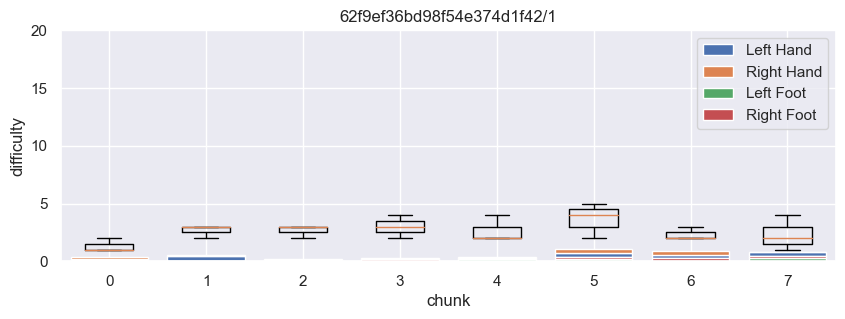

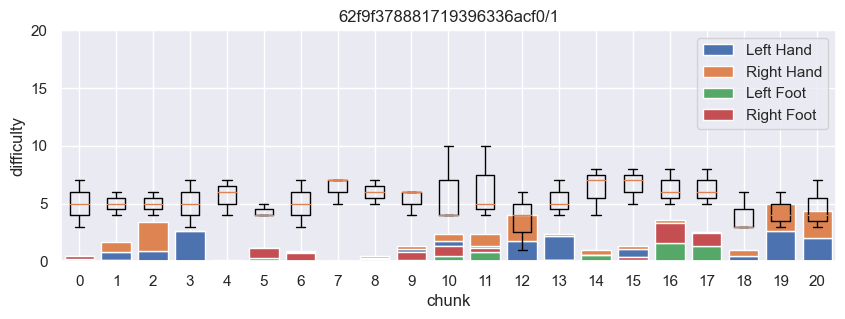

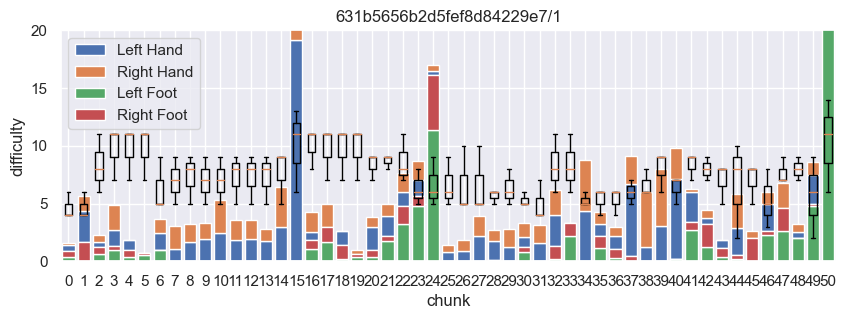

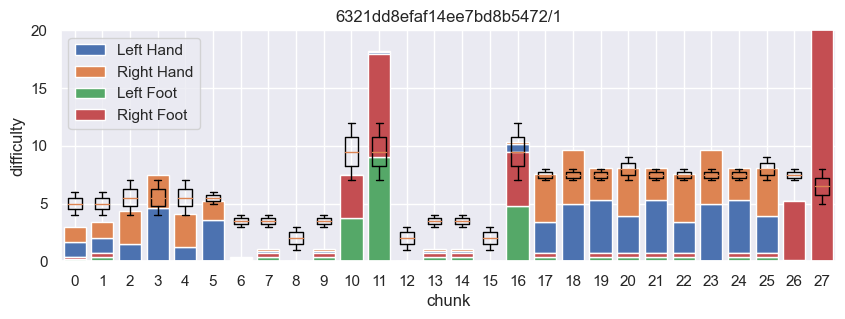

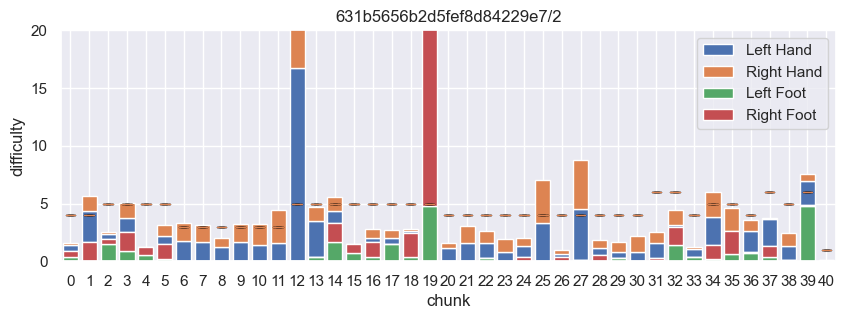

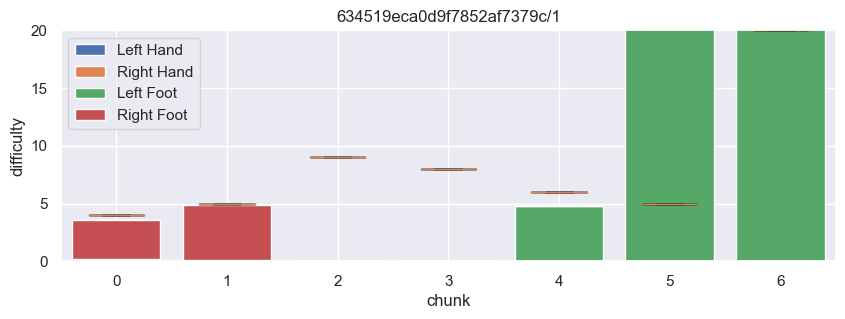

In [131]:
jumpThresholdH = -0.8
jumpThresholdT = 0.5
maxJumpHeight = 1.616
maxJumpSpeed = (2 * maxJumpHeight * gravity) ** 0.5

def handsHeightDifficultyFactor(height):
  return (1.2 * height - 0.4) ** 4 - (0.2 * height) ** 6 + 0.2


def feetHeightDifficultyFactor(height):
  return ((height + 0.875) ** 2.8 + 1)

def jumpHeightDifficulty(height):
  return 10 * (height + 1) ** 3 + 3

def intensity3(obj, lastPositions, state):

  def feetBaseCase():
    # # default (standing) evaluation
    if (distance == 0):
      return 0, state
    return distance / time * feetHeightDifficultyFactor(obj[1]), state

  distance = ((lastPositions[obj[3]][0] - obj[0]) ** 2 + (lastPositions[obj[3]][1] - obj[1]) ** 2) ** 0.5
  time = abs(lastPositions[obj[3]][2] - obj[2])
  if (time == 0):
    return math.inf, {}

  # Hands
  if (obj[3] == 6 or obj[3] == 7):
    if (distance == 0):
      return 0, state
    return distance / time * handsHeightDifficultyFactor(obj[1]), state
  # Feet
  elif (obj[3] == 8 or obj[3] == 9):
    otherFoot = lastPositions[9 if obj[3] == 8 else 8]

    # todo: Refine. E.g. higher difficulty with larger d, higher difficulty for horizontal movement
    if state.get('status') == 'jump':
      base = state.get('left_base' if obj[3] == 8 else 'right_base')
      print('---')
      pprint.pprint(obj)
      pprint.pprint(base)
      print('---')
      t = obj[2] - base[2]
      b = np.array(base[:2])
      o = np.array(obj[:2])
      v_y = state.get('velocity')
      arcPos = np.subtract(np.add(b, np.multiply(v_y, t)), np.multiply(np.array([0, 1]), 0.5 * gravity * t ** 2))
      if arcPos[1] < -0.875:
        state = {}
        return feetBaseCase()
      d = np.linalg.norm(np.subtract(np.add(arcPos, state.get('arc_deviation')), o)) / t
      if (d < 0.1):
        print ("d < 0.1")
        return 600 * d**2, {
          'status': 'jump',
          'left_base': state.get('left_base'),
          'right_base': state.get('right_base'),
          'arc_deviation': np.subtract(arcPos, o),
        }
      else:
        print ("d >= 0.1")
        return math.inf, {}
    
    if (state.get('status') == 'jump_arc_determination'):
      # Check if landing, then jumping again was possible.
      t_1 = math.sqrt( 2 * lastPositions[obj[3]][2] / gravity )
      t_2 = math.sqrt( 2 * obj[2] / gravity )
      if (obj[2] > lastPositions[obj[3]][2] + t_1 + t_2):
        state = {}
        return feetBaseCase()

      # These calculations are derived from solving the following system.
      #
      # | v(t_1 - t_0) - 0.5g(t_1 - t_0)^2 = h_1 |
      # | v(t_2 - t_0) - 0.5g(t_2 - t_0)^2 = h_2 |
      #
      # Where
      #   v is the initial speed of an ideal jump
      #   g is gravity
      #   t_0 is the time of leaving the ground
      #   t_1 is the time of the first collectible of the jump
      #   t_2 is the time of the second collectible of the jump
      #   h_1 is the height of the first collectible of the jump
      #   h_2 is the height of the second collectible of the jump
      #
      # For an ideal jump, one could add similar equations with t_n, h_n
      # where n is a natural number greater than 2. The resulting system
      # with n equations would still be solvable until a t_n is added
      # where the jump has already ended, because the ground was hit.
      # We will count deviations from the ideal curve of a jump with
      # progressively higher difficulty as players still have the ability
      # to control the position of their feet in relation to their body
      # while in the air - although doing that is significantly more
      # difficult than staying in the natural curve of a jump.

      t_1 = lastPositions[obj[3]][2]
      t_2 = obj[2]
      h_1 = lastPositions[obj[3]][1] + 1 # +1, because solution assumes a coordinate system where h >= 0, todo: handle cases where someone placed a collectible outside of the playing field
      h_2 = obj[1] + 1 # +1, because solution assumes a coordinate system where h >= 0
      v_y = 0.5 / (t_2 - t_1) * math.sqrt( 
        gravity**2 * ( t_2 - t_1 )**4 
        + 4 * gravity * ( t_1**2 + t_2**2 ) * ( h_1 + h_2)
        - 8 * t_1 * t_2 * gravity * ( h_1 + h_2 )
        + 5 * ( h_2 - h_1 )**2)
      t_0 = t_1 - v_y/gravity + math.sqrt( v_y**2 / gravity**2 - 2 * h_1 / gravity )
      # Assume linear velocity for x direction to be easiest.
      v_x = (obj[0] - lastPositions[obj[3]][0]) / (t_2 - t_1)

      # Determine maximum height of jump and add difficulty immediately 
      # in favor of exploring non-jump options first as they tend to be easier.
      # (Also simplifies code.)
      # For subsequent collectibles on the jump path, difficulty will only be
      # added for deviation from the ideal jump path.
      h_max = v_y**2 / ( 2 * gravity )

      # This fails to explicitly account for removing the feet base case
      # difficulty associated with the first collectible of the jump.
      # However, especially by subtracting a hand-picked constant in 
      # jumpHeightDifficulty this effect should be negligible.
      return jumpHeightDifficulty(h_max - 1) - state.get('buffered_difficulty'), { # -1, because solutions assumes a coordinate system where h >= 0
        'status': 'jump',
        'left_base': obj[:3] if obj[3] == 8 else lastPositions[8][:3],
        'right_base': obj[:3] if obj[3] == 9 else lastPositions[9][:3],
        'velocity': [v_x, v_y],
        'arc_deviation': np.zeros(2)
      }

    # detect jump
    if (obj[1] > jumpThresholdH and 
        otherFoot[1] > jumpThresholdH and
        obj[2] - otherFoot[2] < jumpThresholdT): # this line could cause counting too many jumps, if jump_start case is not handled above
      # todo: Allow some backtracking in order to get consistent intensities for jumps?
      # todo: Think about monkey patching difficulty of otherFoot instead of just returning higher difficulty for one foot for more balanced feet intensity.
      # Not important for overall difficulty. Probably not worth the effort.
      difficulty = jumpHeightDifficulty(obj[1])
      return difficulty, {
        'status': 'jump_arc_determination',
        'buffered_difficulty': difficulty
      }

    return feetBaseCase()
  return math.inf, {}

plotSampledGetMinIntensityDijkstra(intensity3)